In [1]:
import io
import re
import string
import tqdm

import numpy as np

import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt

import nltk


c:\Users\youne\anaconda3\envs\gee_env\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [84]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=seed,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [85]:
from datasets import load_dataset

path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
with open(path_to_file) as f:
  lines = f.read().splitlines()
for line in lines[:20]:
  print(line)
  

text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.


In [107]:
# Now, create a custom standardization function to lowercase the text and
# remove punctuation.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')


# Define the vocabulary size and the number of words in a sequence.
vocab_size = 4096
sequence_length = 20

# Use the `TextVectorization` layer to normalize, split, and map strings to
# integers. Set the `output_sequence_length` length to pad all samples to the
# same length.
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(text_ds.batch(1024))
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('to'), np.str_('i'), np.str_('of'), np.str_('you'), np.str_('my'), np.str_('a'), np.str_('that'), np.str_('in'), np.str_('is'), np.str_('not'), np.str_('for'), np.str_('with'), np.str_('me'), np.str_('it'), np.str_('be'), np.str_('your')]


In [108]:
# Vectorize the data in text_ds.
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

32777


In [109]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=3,
    num_ns=6,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|██████████| 32777/32777 [01:13<00:00, 446.86it/s]




targets.shape: (89729,)
contexts.shape: (89729, 7)
labels.shape: (89729, 7)


In [110]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 7), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 7), dtype=tf.int64, name=None))>


In [111]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim)

  def call(self, pair):
    target, context = pair

    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    word_emb = self.target_embedding(target)
    context_emb = self.context_embedding(context)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots
  
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [112]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

In [113]:
embedding_dim = 256
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
history = word2vec.fit(dataset, epochs=20)


Epoch 1/20


87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.2077 - loss: 1.8928
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.5492 - loss: 1.3573
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.7751 - loss: 0.7109
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.8381 - loss: 0.4866
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8559 - loss: 0.4169
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8661 - loss: 0.3803
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8703 - loss: 0.3632
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8741 - loss: 0.3510
Epoch 9/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8769 - loss: 0.3419
Epoch 10/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.8783 - loss: 0.3352
Epoch 11/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.8783 - loss: 0.3302
Epoch 12/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.8801 - l

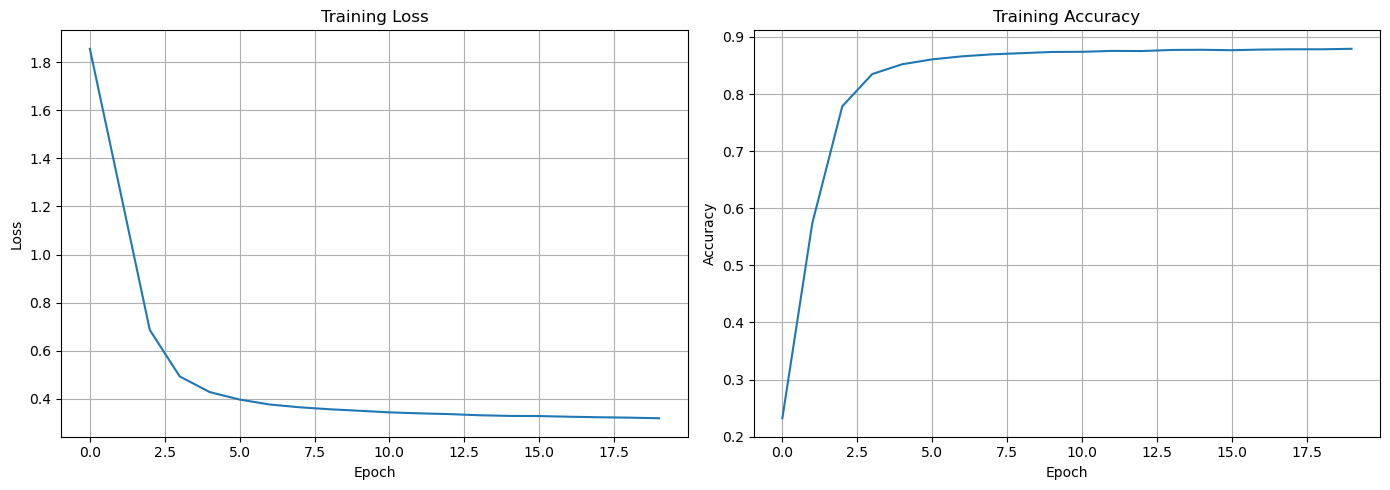

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'])
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history.history['accuracy'])
axes[1].set_title('Training Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

In [116]:
# Cell 10: Extract Embeddings and Evaluation Functions

weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
print(f"Embedding matrix shape: {weights.shape}")


Embedding matrix shape: (4096, 256)


In [117]:
# Embedding Quality Assessment Functions
from sklearn.metrics.pairwise import cosine_similarity

def get_word_index(word):
    """Get the index of a word in the vocabulary."""
    try:
        return inverse_vocab.index(word)
    except ValueError:
        return None

def get_embedding(word):
    """Get the embedding vector for a word."""
    idx = get_word_index(word)
    if idx is not None:
        return weights[idx]
    return None

def find_similar_words(word, top_n=10):
    """Find the most similar words to a given word."""
    word_idx = get_word_index(word)
    if word_idx is None:
        print(f"Word '{word}' not in vocabulary")
        return []
    
    word_vec = weights[word_idx].reshape(1, -1)
    similarities = cosine_similarity(word_vec, weights)[0]
    
    # Get top_n+1 indices (excluding the word itself)
    most_similar_indices = np.argsort(similarities)[::-1][1:top_n+1]
    
    results = []
    for idx in most_similar_indices:
        results.append((inverse_vocab[idx], similarities[idx]))
    
    return results

def word_analogy(word_a, word_b, word_c, top_n=5):
    """Solve word analogy: word_a is to word_b as word_c is to ?"""
    vec_a = get_embedding(word_a)
    vec_b = get_embedding(word_b)
    vec_c = get_embedding(word_c)
    
    if vec_a is None or vec_b is None or vec_c is None:
        print("One or more words not in vocabulary")
        return []
    
    # Compute: word_b - word_a + word_c
    result_vec = vec_b - vec_a + vec_c
    result_vec = result_vec.reshape(1, -1)
    
    similarities = cosine_similarity(result_vec, weights)[0]
    
    # Exclude input words
    exclude_indices = {get_word_index(word_a), get_word_index(word_b), get_word_index(word_c)}
    
    most_similar_indices = np.argsort(similarities)[::-1]
    
    results = []
    for idx in most_similar_indices:
        if idx not in exclude_indices:
            results.append((inverse_vocab[idx], similarities[idx]))
        if len(results) >= top_n:
            break
    
    return results

In [118]:
# Test Similar Words
test_words = ['king', 'love', 'death', 'man', 'good', 'heart']

print("=" * 50)
print("WORD SIMILARITY TEST")
print("=" * 50)

for word in test_words:
    similar = find_similar_words(word, top_n=5)
    if similar:
        print(f"\nWords similar to '{word}':")
        for sim_word, score in similar:
            print(f"  {sim_word}: {score:.4f}")

WORD SIMILARITY TEST

Words similar to 'king':
  vi: 0.3227
  bishops: 0.3077
  extremity: 0.3065
  spies: 0.3061
  ii: 0.2923

Words similar to 'love':
  doubtful: 0.3325
  world: 0.2826
  ascend: 0.2794
  executioner: 0.2734
  perforce: 0.2713

Words similar to 'death':
  trees: 0.3173
  doors: 0.2936
  mockd: 0.2914
  emilia: 0.2886
  unfit: 0.2700

Words similar to 'man':
  thread: 0.3854
  mopsa: 0.3623
  rash: 0.3466
  calm: 0.3435
  bears: 0.3362

Words similar to 'good':
  mercutio: 0.2856
  against: 0.2624
  considered: 0.2574
  ladyship: 0.2535
  amends: 0.2529

Words similar to 'heart':
  wit: 0.3503
  went: 0.3435
  remorse: 0.2972
  ease: 0.2961
  changes: 0.2926


In [119]:
# Test Word Analogies
print("=" * 50)
print("WORD ANALOGY TEST")
print("=" * 50)

# Try some analogies (may not work well with small dataset)
analogies = [
    ('man', 'king', 'woman'),  # man:king :: woman:?
    ('good', 'better', 'bad'),  # good:better :: bad:?
]

for word_a, word_b, word_c in analogies:
    print(f"\n{word_a} : {word_b} :: {word_c} : ?")
    results = word_analogy(word_a, word_b, word_c)
    for word, score in results:
        print(f"  {word}: {score:.4f}")

WORD ANALOGY TEST

man : king :: woman : ?
  richmond: 0.3551
  dare: 0.3231
  mystery: 0.3217
  wonder: 0.3108
  because: 0.3093

good : better :: bad : ?
  adrian: 0.3315
  reply: 0.3315
  violate: 0.3265
  appear: 0.3003
  challenge: 0.2960


EMBEDDING STATISTICS
Embedding norms - Mean: 4.2360, Std: 1.0412
Embedding norms - Min: 0.4247, Max: 7.1818

Pairwise similarity (sample of 500 words):
  Mean: 0.0347
  Std: 0.1181


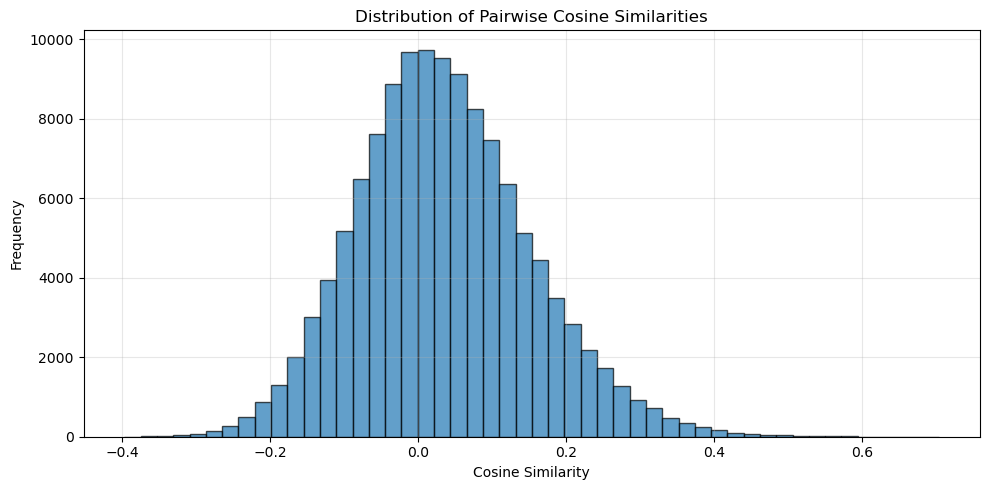

In [105]:
# Compute Embedding Statistics
print("=" * 50)
print("EMBEDDING STATISTICS")
print("=" * 50)

# Compute norms of embeddings
norms = np.linalg.norm(weights, axis=1)
print(f"Embedding norms - Mean: {norms.mean():.4f}, Std: {norms.std():.4f}")
print(f"Embedding norms - Min: {norms.min():.4f}, Max: {norms.max():.4f}")

# Compute average pairwise similarity (sample)
sample_size = 500
sample_indices = np.random.choice(len(weights), min(sample_size, len(weights)), replace=False)
sample_weights = weights[sample_indices]
sample_similarities = cosine_similarity(sample_weights)

# Get upper triangle (excluding diagonal)
upper_triangle = sample_similarities[np.triu_indices(len(sample_weights), k=1)]
print(f"\nPairwise similarity (sample of {len(sample_indices)} words):")
print(f"  Mean: {upper_triangle.mean():.4f}")
print(f"  Std: {upper_triangle.std():.4f}")

# Plot similarity distribution
plt.figure(figsize=(10, 5))
plt.hist(upper_triangle, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Pairwise Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('similarity_distribution.png', dpi=150)
plt.show()

In [121]:
# Interactive Word Exploration
def explore_word(word):
    """Comprehensive exploration of a word's embedding."""
    idx = get_word_index(word)
    if idx is None:
        print(f"Word '{word}' not in vocabulary")
        return
    
    embedding = weights[idx]
    
    print(f"Word: '{word}' (index: {idx})")
    print(f"Embedding norm: {np.linalg.norm(embedding):.4f}")
    print(f"Embedding mean: {embedding.mean():.4f}")
    print(f"Embedding std: {embedding.std():.4f}")
    
    print(f"\nTop 10 similar words:")
    for sim_word, score in find_similar_words(word, top_n=10):
        print(f"  {sim_word}: {score:.4f}")

# Explore some key words from Shakespeare
explore_word('love')
print("\n" + "="*50 + "\n")
explore_word('king')

Word: 'love' (index: 77)
Embedding norm: 4.6236
Embedding mean: 0.0240
Embedding std: 0.2880

Top 10 similar words:
  doubtful: 0.3325
  world: 0.2826
  ascend: 0.2794
  executioner: 0.2734
  perforce: 0.2713
  sanctuary: 0.2694
  subject: 0.2691
  sister: 0.2686
  bondage: 0.2644
  seek: 0.2599


Word: 'king' (index: 35)
Embedding norm: 4.1104
Embedding mean: 0.0089
Embedding std: 0.2567

Top 10 similar words:
  vi: 0.3227
  bishops: 0.3077
  extremity: 0.3065
  spies: 0.3061
  ii: 0.2923
  glory: 0.2831
  yoke: 0.2744
  3: 0.2692
  dreams: 0.2617
  also: 0.2601
